In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from skimage.color import gray2rgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

! pip install gdown
!gdown "https://drive.google.com/uc?id=1Q7YxZ5zMAab9cHWVbYiX2Jdue8229jx8"

import pickle
model_inception_v3 = pickle.load(open('inception_model.dt', 'rb'))

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract = True, use_pretrained=True):
    model_ft = None
    input_size = 0
    if model_name == "inception":
        model_ft = model_inception_v3
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    return model_ft, input_size

/kaggle/input/facial-keypoints-detection/test.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.11.0-py3-none-any.whl size=9619 sha256=c96f851c71ed8751b84518a52459a1683c8938a084603453ebb6fba50bd6967e
  Stored in directory: /root/.cache/pip/wheels/05/e6/10/9cbfea8dcf9fde0f406da1e4c71d5c3cf3c99e0502d7f08ac6
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1Q7YxZ5zMAab9cHWVbYiX2Jdue8229jx8
To: /kaggle/working/inception_model.dt
97.8MB [00:01, 95.1MB/s]


In [2]:
class Dataset2D(Dataset):
    def convert_to_matrix(self,data):
        return np.array(data.split(' '),dtype=float).reshape(96,96) # Images are 96 * 96

    def __init__(self,filename):
        input_data = pd.read_csv(filename)
        #Seperate X,y
        self.X = input_data['Image'].to_numpy()
        input_data.drop(['Image'], axis=1, inplace=True)
        self.Y = input_data.to_numpy()
        self.len = input_data.shape[0]
        return
    def __getitem__(self,index):
        x = torch.from_numpy(gray2rgb(resize(self.convert_to_matrix(self.X[index]),(299,299)))).type(torch.FloatTensor).permute(2,0,1) / 255
        x = x.type(torch.cuda.FloatTensor)
        y = torch.from_numpy(self.Y[index]).type(torch.cuda.FloatTensor)
        return x,y
    def __len__(self):
        return self.len

In [3]:
model_ft, input_size = initialize_model('inception', 30,feature_extract = True, use_pretrained=True)

In [5]:
dataset=Dataset2D("/kaggle/input/facial-keypoints-detection/training.zip")
dataset_loader = DataLoader(dataset=dataset,batch_size=256)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=True):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()
        running_loss = 0.0
        batch = 1
        total_batch = 7049 / 256
        for x,y in dataset_loader:
            print('Batch {}/{}'.format(batch, total_batch))
            batch += 1
            optimizer.zero_grad()
            outputs, aux_outputs = model(x)
            #To handle Nan in y -> assuming our output is correct to predict them
            non_final_mask = (y != y)
            if non_final_mask.any():
                y[non_final_mask] = outputs[non_final_mask]

            loss1 = criterion(outputs, y)
            loss2 = criterion(aux_outputs, y)
            loss = loss1 + 0.4 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss
        print("Epoch Loss : ",epoch_loss)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model
        

In [7]:
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.MultiLabelSoftMarginLoss() # For multilabel classifiers -> where output is multible labels

	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [8]:
model_ft.to("cuda")
model_ft.train()
model_trained = train_model(model_ft,dataset_loader,criterion,optimizer_ft,num_epochs=1)

Epoch 0/0
----------
Batch 1/27.53515625
Batch 2/27.53515625
Batch 3/27.53515625
Batch 4/27.53515625
Batch 5/27.53515625
Batch 6/27.53515625
Batch 7/27.53515625
Batch 8/27.53515625
Batch 9/27.53515625
Batch 10/27.53515625
Batch 11/27.53515625
Batch 12/27.53515625
Batch 13/27.53515625
Batch 14/27.53515625
Batch 15/27.53515625
Batch 16/27.53515625
Batch 17/27.53515625
Batch 18/27.53515625
Batch 19/27.53515625
Batch 20/27.53515625
Batch 21/27.53515625
Batch 22/27.53515625
Batch 23/27.53515625
Batch 24/27.53515625
Batch 25/27.53515625
Batch 26/27.53515625
Batch 27/27.53515625
Batch 28/27.53515625
Epoch Loss :  -32150.1839966774

Training complete in 1m 17s


In [10]:
torch.save(model_trained.state_dict(),'trained_model.dt')

In [11]:
model_trained.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [40]:
%matplotlib inline
def convert_to_matrix(data):
    return np.array(data.split(' '),dtype=float).reshape(96,96)
def show_feature_on_image(x,y,y_o):
    x = convert_to_matrix(x)
    plt.imshow(x, cmap='gray')
    y = y.cpu().numpy().reshape(-1,2)
    y_o = y_o.reshape(-1,2)
    plt.scatter(y[:, 0], y[:, 1], s=24, marker ='.', c='r')
    plt.scatter(y_o[:, 0], y_o[:, 1], s=24, marker ='x', c='g')

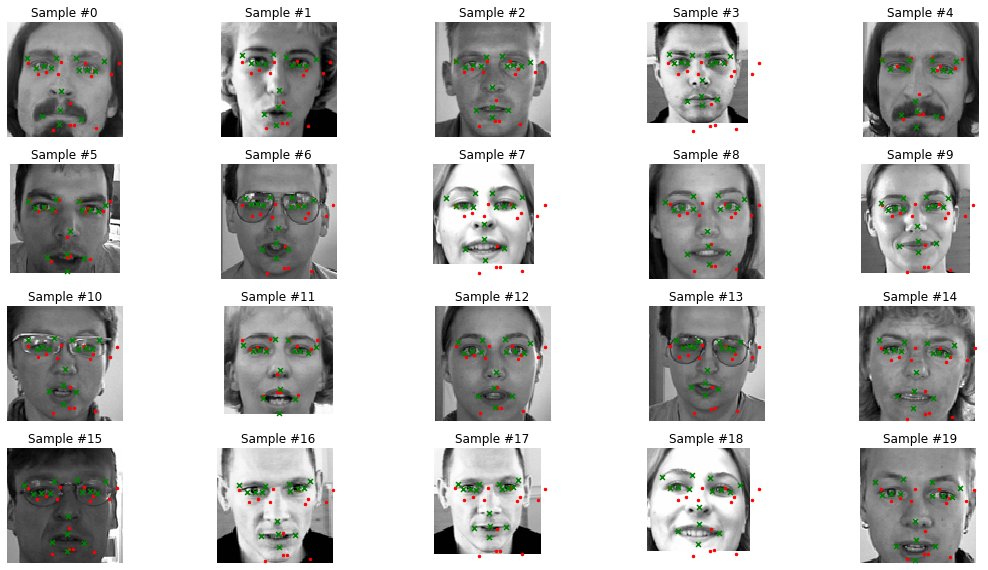

In [41]:
plt.figure(figsize=(15,10))
RANGE = 20
COLS = 5
nrows = RANGE // COLS + 1
for label in range(RANGE):
    x = dataset.X[label]
    y = dataset.Y[label]
    x_tensor = torch.from_numpy(gray2rgb(resize(convert_to_matrix(x),(299,299)))).type(torch.FloatTensor).permute(2,0,1).unsqueeze(0) / 255
    x_tensor = x_tensor.type(torch.cuda.FloatTensor)
    y_predict = model_trained(x_tensor)
    plt.subplot(nrows,COLS,label+1)
    plt.title(f'Sample #{label}')
    plt.axis('off')
    plt.tight_layout()
    show_feature_on_image(x,y_predict.detach(),y)
    